# Kwantowe sieci neuronowe w modelowaniu regresji 



In [1]:
import pennylane as qml
import pennylane.numpy as np

sim = 'default.qubit'

In [2]:
inputs = np.array([np.pi*0.7, np.pi/3], requires_grad=False)

weights = np.array([1.2, 0.4, 0.3] , requires_grad=True)

In [7]:
dev1 = qml.device(sim, wires=2, shots=1000)

@qml.qnode(dev1)
def vqa(inputs, weights):
    qml.RY(inputs[0], wires=0)
    qml.RY(inputs[1], wires=1)
    qml.Barrier()

    qml.RX(weights[0], wires=0)
    qml.RY(weights[1], wires=1)
    qml.CZ(wires=[0,1])
    qml.RY(weights[2], wires=1)
    qml.Barrier()
    return qml.probs(wires=range(2))

/Users/seba/Documents/GitHub/qml2025/venv/lib/python3.13/site-packages/pennylane/devices/device_api.py:193: PennyLaneDeprecationWarning: Setting shots on device is deprecated. Please use the `set_shots` transform on the respective QNode instead.
  warnings.warn(


(<Figure size 700x300 with 1 Axes>, <Axes: >)

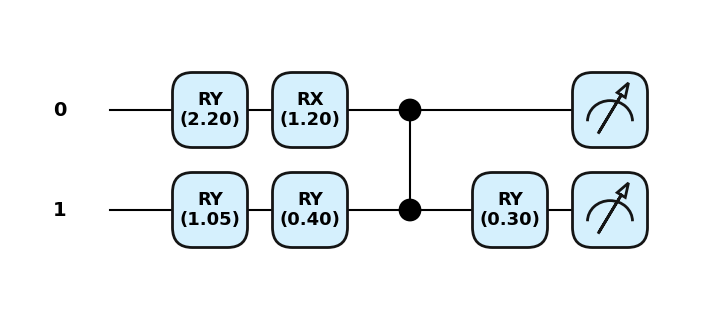

In [8]:
qml.draw_mpl(vqa, scale=0.7, style='pennylane', decimals=2, level='device')(inputs, weights)

In [12]:
vqa(inputs, weights), vqa(inputs, weights), vqa(inputs, weights)

(array([0.16 , 0.238, 0.433, 0.169]),
 array([0.173, 0.236, 0.43 , 0.161]),
 array([0.163, 0.235, 0.432, 0.17 ]))

In [11]:
qml.gradients.param_shift(vqa)(inputs, weights)

array([[ 0.115 , -0.201 , -0.1855],
       [ 0.1625,  0.1945,  0.191 ],
       [-0.1895, -0.272 ,  0.284 ],
       [-0.088 ,  0.2785, -0.2895]])

## proste modele regresyjne


In [18]:
X = np.linspace(0, 2*np.pi, 5) 
X.requires_grad = False
Y = np.sin(X) 

X_test = np.linspace(0.2, 2*np.pi+0.2, 5)
Y_test = np.sin(X_test)

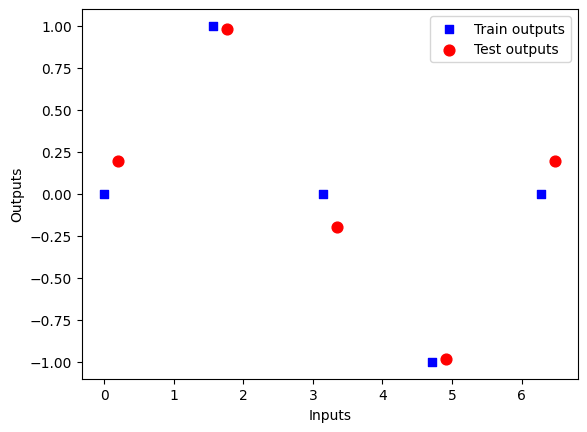

In [19]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(X, Y, s=30, c='b', marker="s", label='Train outputs')
ax1.scatter(X_test,Y_test, s=60, c='r', marker="o", label='Test outputs')
plt.xlabel("Inputs")
plt.ylabel("Outputs")

plt.legend(loc='upper right');
plt.show()

In [20]:
dev = qml.device('default.qubit', wires=1)
@qml.qnode(dev)
def qreg(datapoint, params):
    qml.RX(datapoint, wires=0)
    qml.RY(params, wires=0)
    #qml.Rot(params[0], params[1], params[2], wires=0)
    return qml.expval(qml.PauliZ(wires=0))

(<Figure size 500x200 with 1 Axes>, <Axes: >)

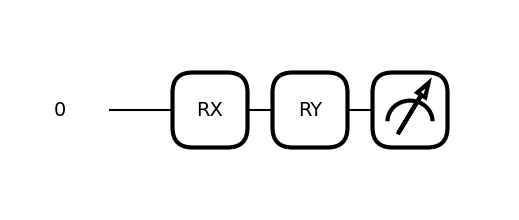

In [21]:
qml.draw_mpl(qreg)([0.1],[0.2])

In [22]:
[qreg(x, 0.5)  for x in X] 

[tensor(0.87758256, requires_grad=True),
 tensor(1.11022302e-16, requires_grad=True),
 tensor(-0.87758256, requires_grad=True),
 tensor(-1.11022302e-16, requires_grad=True),
 tensor(0.87758256, requires_grad=True)]

In [23]:
def loss_func(predictions):
 
    total_losses = 0
    for i in range(len(Y)):
        output = Y[i]
        prediction = predictions[i]
        loss = (prediction - output)**2
        total_losses += loss
    return total_losses

In [24]:
def cost_fn(params):
    predictions = [qreg(x, params)  for x in X]
    cost = loss_func(predictions)
    return cost

In [25]:
opt = qml.GradientDescentOptimizer(stepsize=0.2)

params = np.array([0.4], requires_grad=True)

for i in range(100):
    params, prev_cost = opt.step_and_cost(cost_fn, params)
    if i%10 == 0:
        print(f'Step = {i} Cost = {cost_fn(params)}')

Step = 0 Cost = [3.36513589]
Step = 10 Cost = [2.]
Step = 20 Cost = [2.]
Step = 30 Cost = [2.]
Step = 40 Cost = [2.]
Step = 50 Cost = [2.]
Step = 60 Cost = [2.]
Step = 70 Cost = [2.]
Step = 80 Cost = [2.]
Step = 90 Cost = [2.]


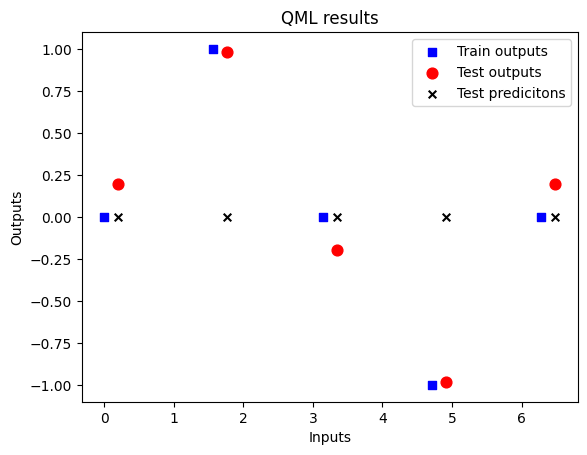

In [26]:
test_predictions = []
for x_test in X_test:
    prediction = qreg(x_test, params)
    test_predictions.append(prediction)

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(X, Y, s=30, c='b', marker="s", label='Train outputs')
ax1.scatter(X_test,Y_test, s=60, c='r', marker="o", label='Test outputs')
ax1.scatter(X_test,test_predictions, s=30, c='k', marker="x", label='Test predicitons')
plt.xlabel("Inputs")
plt.ylabel("Outputs")
plt.title("QML results")

plt.legend(loc='upper right');
plt.show()

### QNN template

In [27]:
import pennylane as qml
import pennylane.numpy as np

n_qubits = 3
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def quantum_regression(datapoint, params):
    qml.AngleEmbedding(datapoint, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(params, wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0))

In [28]:
shape = qml.StronglyEntanglingLayers.shape(n_layers=2, n_wires=n_qubits)
shape

(2, 3, 3)

In [29]:
inputs = [0.3]
params = np.random.random(size=shape)

print(inputs, params)

[0.3] [[[0.11282513 0.72564779 0.21595164]
  [0.98078925 0.204768   0.712829  ]
  [0.35530699 0.42168993 0.61578077]]

 [[0.51455643 0.24840436 0.76422136]
  [0.07528059 0.41880629 0.36329945]
  [0.47308219 0.26640078 0.63166918]]]


Matplotlib is building the font cache; this may take a moment.


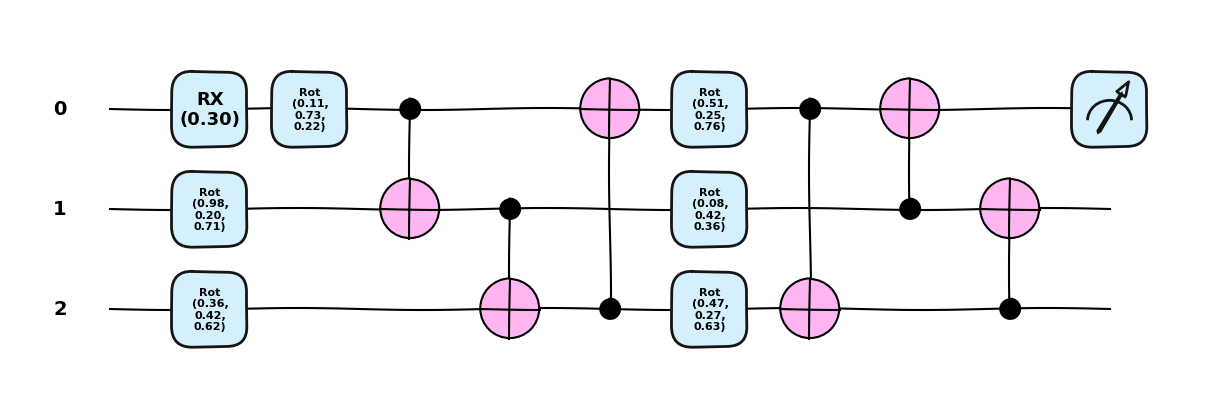

In [30]:
import matplotlib.pyplot as plt
qml.drawer.use_style("pennylane_sketch")
fig, ax = qml.draw_mpl(quantum_regression, decimals=2,level='device')(inputs, params)
plt.show()

In [32]:
def cost_fn(params):
    predictions = [quantum_regression([x], params)  for x in X]
    cost = loss_func(predictions)
    return cost

In [33]:
for i in range (100):
    params, prev_cost = opt.step_and_cost(cost_fn, params)
    if i%10 == 0:
        print(f'Step = {i} Cost = {cost_fn(params)}')

Step = 0 Cost = 1.6750134901195395
Step = 10 Cost = 0.010468152498413093
Step = 20 Cost = 0.0024648568256249092
Step = 30 Cost = 0.0010817200905668901
Step = 40 Cost = 0.0006070350983908127
Step = 50 Cost = 0.0003888980331095931
Step = 60 Cost = 0.0002706936774535423
Step = 70 Cost = 0.0001994395953619091
Step = 80 Cost = 0.0001531545104738453
Step = 90 Cost = 0.0001213765221163838


In [34]:
test_predictions = []
for x_test in X_test:
    prediction = quantum_regression([x_test],params)
    test_predictions.append(prediction)

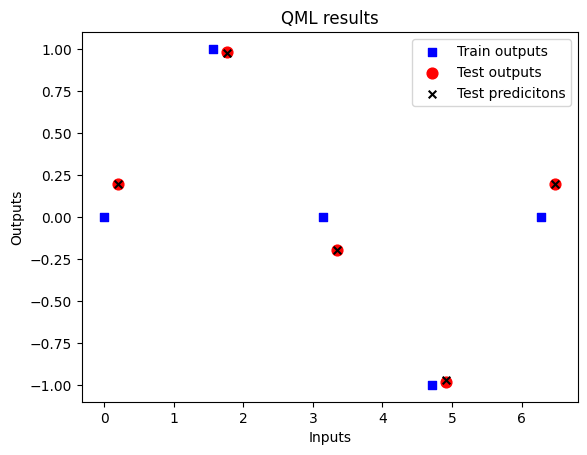

In [35]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(X, Y, s=30, c='b', marker="s", label='Train outputs')
ax1.scatter(X_test,Y_test, s=60, c='r', marker="o", label='Test outputs')
ax1.scatter(X_test,test_predictions, s=30, c='k', marker="x", label='Test predicitons')
plt.xlabel("Inputs")
plt.ylabel("Outputs")
plt.title("QML results")

plt.legend(loc='upper right')
plt.show()

## Architektury modeli QTSA

Kwantowa analiza szeregów czasowych (QTSA) opiera się na wariacyjnych obwodach kwantowych zaprojektowanych do aproksymowania funkcji mapujących wejściowe dane zależne od czasu na przewidywane wyniki. 
Każdy model QTSA jest rozszerzeniem generycznej Kwantowej Sieci Neuronowej (QNN), którą można wyrazić jako sparametryzowany obwód kwantowy:

$$
U(x,\theta)=U_{ansatz}(\theta)⋅U_{enc}(x),
$$
gdzie $x$ oznacza klasyczne dane wejściowe, $\theta$ to trenowalne parametry, 
$U_{enc}$ koduje klasyczne dane w stany kwantowe, a $U_{ansatz}$ stosuje trenowalne transformacje. 

Przewidywanie uzyskuje się poprzez pomiar wartości oczekiwanej obserwabli $M$:

$$
y = \bra{0}^{\otimes q} U^\dagger M U \ket{0}^{\otimes q}, 
$$

gdzie $q$ jest liczbą kubitów, a $M=\sum_{j=1}^{q} Z_j$, chyba że zaznaczono inaczej.


### Modele dopasowania krzywych

Modele QTSA dopasowania krzywych aproksymują funkcję ciągłą $f:R\to R$, 
przewidując wartości szeregu czasowego w pojedynczych krokach czasowych.

Charakteryzują się one wielokrotnym ponownym ładowaniem danych wejściowych $\{x_i\}$ do obwodu w celu uchwycenia struktury sekwencyjnej. 

Rozważane są trzy warianty:

1. Szeregowe Ponowne Ładowanie (PQFT-Serial)

Dla pojedynczego kubitu, model naprzemiennie stosuje sparametryzowane unitarne ansatze i powtarzane unitarne kodowania. Unitarne kodowanie jest wybierane jako rotacja wokół osi $X$, a każde unitarne ansatze jest uniwersalną bramką jednokubitową $U(\theta)$ sparametryzowaną trzema trenowalnymi kątami.

Niech $x \in \mathbb{R}$ będzie skalarną wartością wejściową (np. pojedynczy krok czasowy), a $n$ oznacza liczbę warstw ponownego ładowania danych. 
Każda bramka ansatze $U(\theta_k)$ jest zdefiniowana przez trzy parametry $\theta_k=(\theta_k^{(1)},\theta_k^{(2)},\theta_k^{3})$, a pełny zbiór parametrów to $\theta = \{\theta_1, \dots, \theta_{n+1} \}$.



Wynikowy stan kwantowy po przetworzeniu wejścia x to:
$$
\ket{\psi(x, \theta)} = ( \prod_{j=1}^{n} [U(\theta_j) \cdot R_X(x)]) \cdot U(\theta_{n+1})\ket{0}
$$
gdzie $R_X(x) = exp (−i x X/2)$. 

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

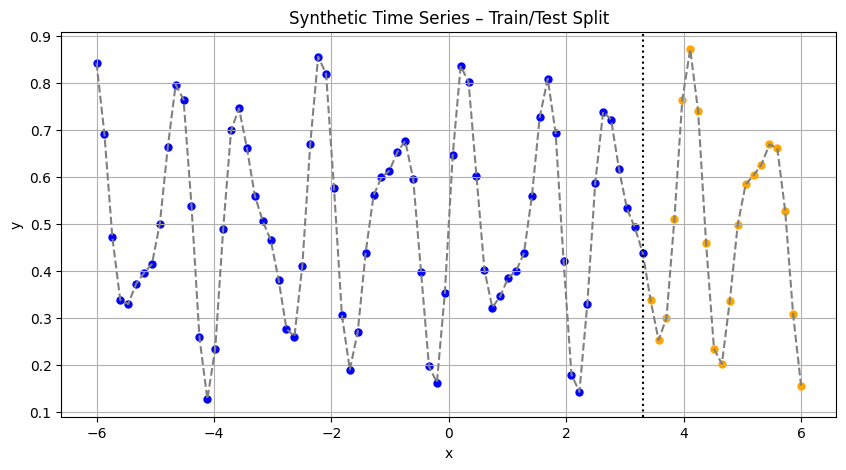

In [2]:
# ==== 1. Dane ====
x_all = np.linspace(-6, 6, 90)
y_all = (np.sin(5.0 * x_all) + 0.5 * np.sin(8.0 * x_all)) / 4 + 0.5

# ==== 2. Podział ====
x_train = x_all[:70]
y_train = y_all[:70]

x_test = x_all[70:]
y_test = y_all[70:]

# ==== 3. Wykres ====
plt.figure(figsize=(10, 5))
plt.plot(x_all, y_all, label="Target function", color="gray", linestyle="--")
plt.scatter(x_train, y_train, label="Train", color="blue", s=25)
plt.scatter(x_test, y_test, label="Test", color="orange", s=25)

# Linia podziału
plt.axvline(x=x_train[-1], color="black", linestyle=":", label="Train/Test split")

#plt.legend()
plt.title("Synthetic Time Series – Train/Test Split")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

In [3]:
dev = qml.device("default.qubit", wires=1)

scaling = 1

def S(x):
    """ kodowanie danych 
    x - wartosc skalarna jednej zmiennej - do przewidywania szeregow czasowych 
    czyli najczęściej to bedzie reprezentować oś czasu.
    scaling - trochę nie wiem po co ale zakładam, ze pozwoli ustalić zakres od 0 do 2pi bo kąty się powtarzają
    """
    qml.RX(scaling * x, wires=0)

def W(theta):
    """
    trenowalny blok zalezacy od 3 katów 
    wymusza aby theta bylo przynajmniej listą (krotką) posiadającą 3 elementy
    minimalny model z zaladowaniem danych [[1.2,0.3,4.5],[1.2,0.3,4.5]] - musi zawierac przynajmniej dwie listy
    """
    qml.Rot(theta[0], theta[1], theta[2], wires=0)

@qml.qnode(dev)
def serial_quantum_model(weights, x):
    for theta in weights[:-1]:
        W(theta)
        S(x)
    W(weights[-1])

    return qml.expval(qml.PauliZ(wires=0))

In [4]:
r = 4
weights = (np.random.random(size=(r+1, 3), requires_grad=True))

In [5]:
weights


tensor([[0.22811526, 0.36255741, 0.67154863],
        [0.97108591, 0.36983219, 0.41593129],
        [0.17374648, 0.56058029, 0.77977962],
        [0.00867151, 0.80233344, 0.33836025],
        [0.68861766, 0.19787254, 0.30560425]], requires_grad=True)

(<Figure size 1200x200 with 1 Axes>, <Axes: >)

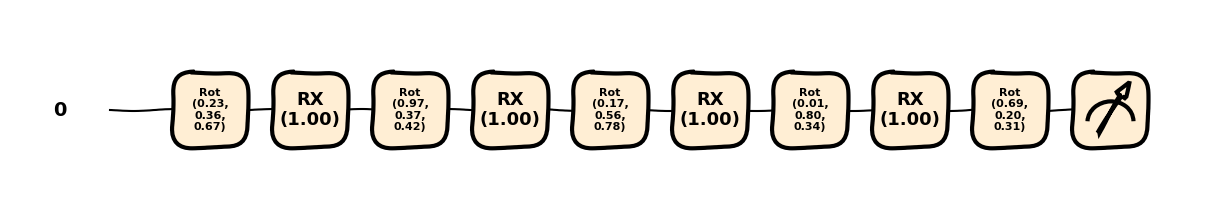

In [6]:
qml.draw_mpl(serial_quantum_model, decimals=2, level="device", style='sketch')(weights, 1.0)

In [7]:
X = np.linspace(-6,6, 200)
results = [serial_quantum_model(weights=weights, x=x_) for x_ in X]

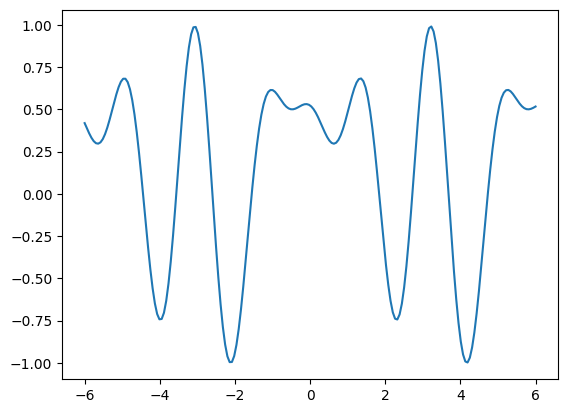

In [8]:
plt.plot(X,results)

In [9]:
# Koszt: MSE
def cost(weights, x_data, y_data):
    preds = np.array([serial_quantum_model(weights, x) for x in x_data])
    return np.mean((preds - y_data) ** 2)

r = 20
weights = (np.random.random(size=(r+1, 3), requires_grad=True))

# Optymalizacja
opt = qml.AdamOptimizer(stepsize=0.1)
epochs = 100

for epoch in range(epochs):
    weights = opt.step(lambda w: cost(w, x_train, y_train), weights)
    if epoch % 10 == 0:
        loss = cost(weights, x_train, y_train)
        print(f"Epoch {epoch}: loss = {loss:.6f}")

Epoch 0: loss = 0.210831
Epoch 10: loss = 0.023146
Epoch 20: loss = 0.009356
Epoch 30: loss = 0.005972
Epoch 40: loss = 0.003265
Epoch 50: loss = 0.001862
Epoch 60: loss = 0.001238
Epoch 70: loss = 0.000985
Epoch 80: loss = 0.000760
Epoch 90: loss = 0.000569


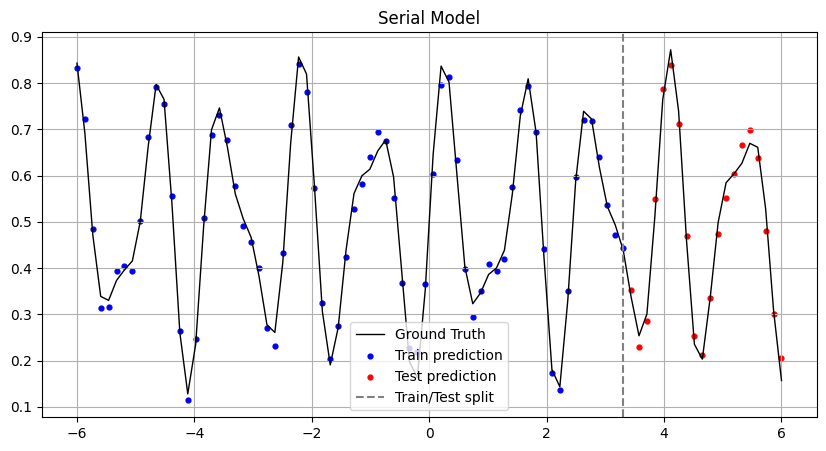

In [10]:
# Predykcje
y_pred_train = np.array([serial_quantum_model(weights, x ) for x in x_train])
y_pred_test = np.array([serial_quantum_model(weights, x) for x in x_test])

# Wykres
plt.figure(figsize=(10, 5))
plt.plot(x_all, y_all, label="Ground Truth", color="black", linewidth=1)
plt.scatter(x_train, y_pred_train, color="blue", label="Train prediction", s=12)
plt.scatter(x_test, y_pred_test, color="red", label="Test prediction", s=12)
plt.axvline(x=x_train[-1], color="gray", linestyle="--", label="Train/Test split")
plt.title("Serial Model")
plt.grid(True)
plt.legend()
plt.show()

## Parallel 

In [ ]:
# Parametry systemu
n_qubits = 3
n_ansatz_layers = 1
m_ansatz_layers = 2

def S(x):
    # RX(x) na wszystkich qubitach
    for i in range(n_qubits):
        qml.RX(x, wires=i)

def U_ent(weights):
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))

def U_q(weights):
    for idx, w in enumerate(weights):
        qml.Rot(w[0], w[1], w[2], wires=idx)

dev = qml.device("default.qubit", wires=n_qubits)


@qml.qnode(device=dev)
def parralel_quantum_model(weights, x):
    
    U_ent(weights[:n_ansatz_layers])

    qml.Barrier()
    
    U_q(weights[n_ansatz_layers+1])
    
    qml.Barrier()
    
    S(x)
    
    qml.Barrier()

    U_ent(weights[n_ansatz_layers+1:-1])

    qml.Barrier()
    
    U_q(weights[-1])

    obs = qml.prod(*[qml.PauliZ(i) for i in range(n_qubits)])

    return qml.expval(obs)

In [12]:
weights = (np.random.random(size=(n_ansatz_layers+1+m_ansatz_layers+1, n_qubits, 3), requires_grad=True))

(<Figure size 1800x400 with 1 Axes>, <Axes: >)


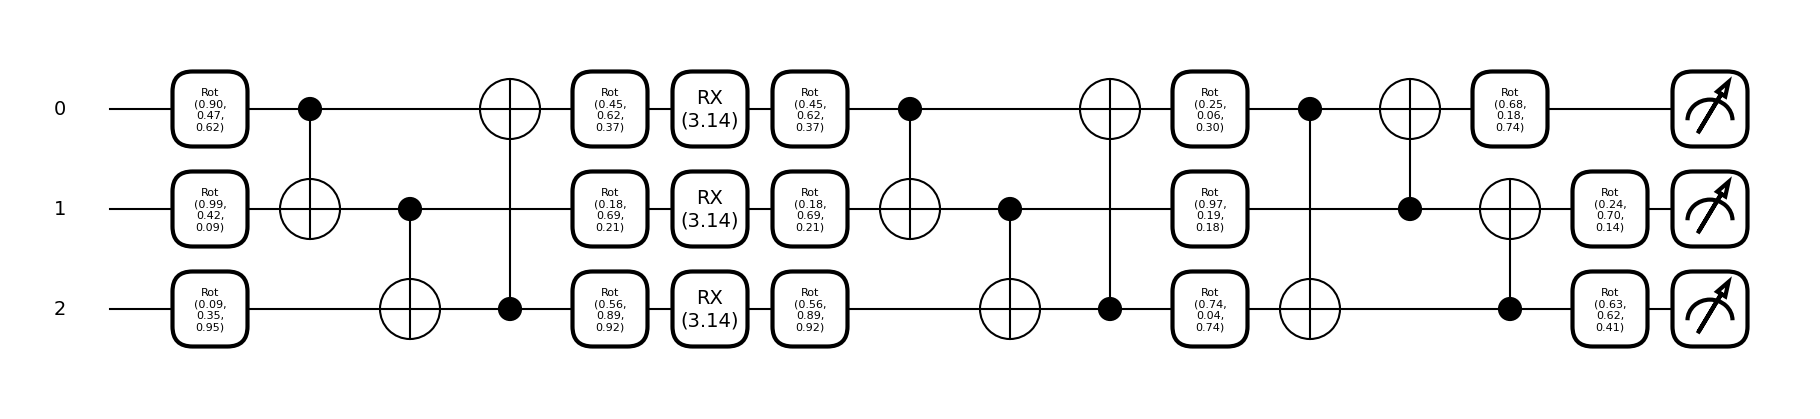

In [13]:
print(qml.draw_mpl(parralel_quantum_model, level="device", decimals=2)(weights, np.pi))

In [14]:
X = np.linspace(-6,6, 200)
results = [parralel_quantum_model(weights, x_) for x_ in X]

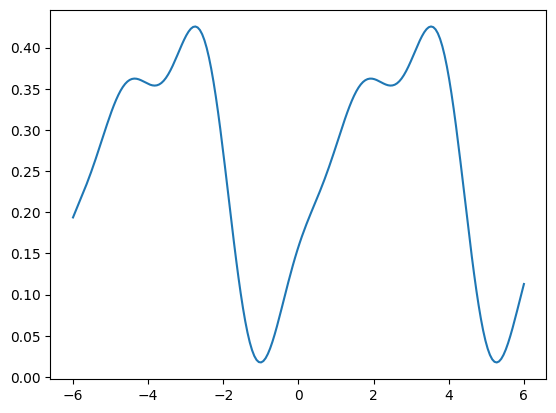

In [15]:
plt.plot(X,results)

In [16]:
# Koszt: MSE
def cost(weights, x_data, y_data):
    preds = np.array([parralel_quantum_model(weights, x) for x in x_data])
    return np.mean((preds - y_data) ** 2)


# Optymalizacja
opt = qml.AdamOptimizer(stepsize=0.1)
epochs = 100

for epoch in range(epochs):
    weights = opt.step(lambda w: cost(w, x_train, y_train), weights)
    if epoch % 10 == 0:
        loss = cost(weights, x_train, y_train)
        print(f"Epoch {epoch}: loss = {loss:.6f}")


Epoch 0: loss = 0.048043
Epoch 10: loss = 0.038311
Epoch 20: loss = 0.038768
Epoch 30: loss = 0.038308
Epoch 40: loss = 0.037880
Epoch 50: loss = 0.037783
Epoch 60: loss = 0.037730
Epoch 70: loss = 0.037712
Epoch 80: loss = 0.037714
Epoch 90: loss = 0.037711


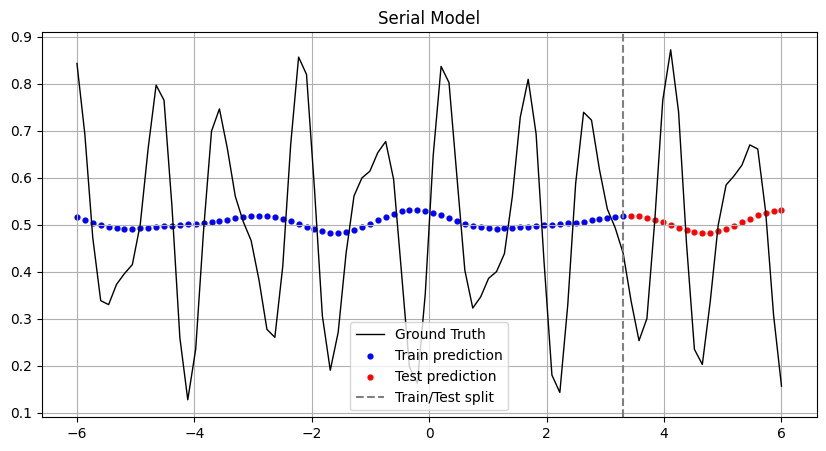

In [17]:
# Predykcje
y_pred_train = np.array([parralel_quantum_model(weights, x ) for x in x_train])
y_pred_test = np.array([parralel_quantum_model(weights, x) for x in x_test])

# Wykres
plt.figure(figsize=(10, 5))
plt.plot(x_all, y_all, label="Ground Truth", color="black", linewidth=1)
plt.scatter(x_train, y_pred_train, color="blue", label="Train prediction", s=12)
plt.scatter(x_test, y_pred_test, color="red", label="Test prediction", s=12)
plt.axvline(x=x_train[-1], color="gray", linestyle="--", label="Train/Test split")
plt.title("Serial Model")
plt.grid(True)
plt.legend()
plt.show()